<a href="https://colab.research.google.com/github/Duclh0403/Recommend_Movie_System/blob/main/Doan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas seaborn
!pip install numpy pandas seaborn scikit-fuzzy matplotlib transformers scikit-learn surprise
!pip install dask[dataframe]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import dask.dataframe as dd
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


In [ ]:
from datetime import datetime
import os
import random
import gc


In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
# Read data
# https://files.grouplens.org/datasets/movielens/ml-32m.zip
links = pd.read_csv('/content/drive/MyDrive/Sample_data/links.csv')
movies = pd.read_csv('/content/drive/MyDrive/Sample_data/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Sample_data/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/Sample_data/tags.csv')

In [ ]:
# Use to identify and count different duplicate rows.
links.duplicated().sum()
movies.duplicated().sum()
ratings.duplicated().sum()
tags.duplicated().sum()

0

<ipython-input-6-dc74e6ab29cc>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


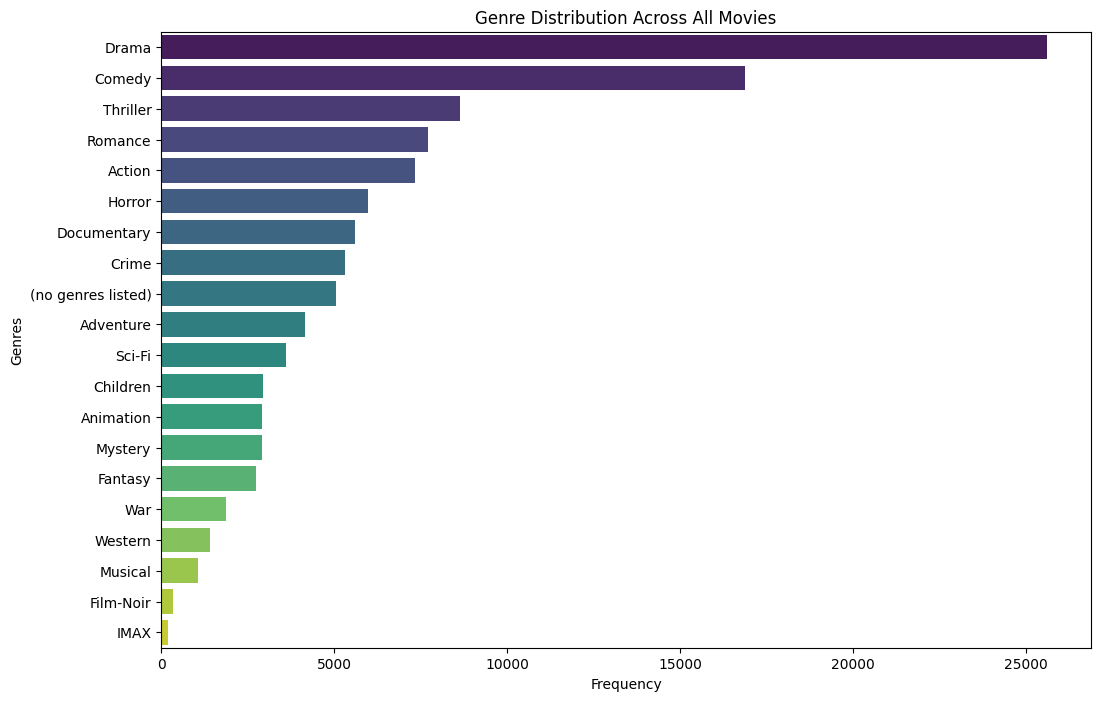

In [ ]:
# Convert 'genres' column to strings
movies['genres'] = movies['genres'].astype(str)

# Split the genres column into separate binary columns
genres_columns = movies['genres'].str.get_dummies(sep='|')

# Concatenate the new genres columns
movies_genres = pd.concat([movies, genres_columns], axis=1)
movies_genres = movies_genres.drop(['nan'], axis=1, errors='ignore')
movies_genres.drop(['genres'], axis=1, inplace=True)

# Assuming the genres columns start from the 2nd column (index 1)
movies_genres_df= movies_genres.drop(['cluster'], axis=1, errors='ignore')
genres_columns = movies_genres_df.columns[2:]

# Calculate the total count of each genre
genre_counts = movies_genres_df[genres_columns].sum().sort_values(ascending=False)

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Genre Distribution Across All Movies')
plt.xlabel('Frequency')
plt.ylabel('Genres')
plt.show()


In [ ]:
# Creating a newId for every movie to reduce the range of existing movieId

movies["newId"] = range(1, movies["movieId"].nunique()+1)

In [ ]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
movies.head()

,movieId,title,genres,newId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,2
2,3,Grumpier Old Men (1995),Comedy|Romance,3
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,4
4,5,Father of the Bride Part II (1995),Comedy,5


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [ ]:
# Converting the the UTC timestamp to Datetime
ratings["timestamp"] = ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

# Merging the movies and ratings data files
ratings = ratings.merge(movies, how="left", on="movieId")

# Renaming the timestamp to date
ratings.rename(columns={"timestamp": "date"}, inplace=True)

# Updating the movieId with the newId
ratings["movieId"] = ratings["newId"]
movies["movieId"] = movies["newId"]

In [ ]:
# Dropping the newId from the datasets
ratings.drop(["newId"], axis=1, inplace=True)
movies.drop(["newId"], axis=1, inplace=True)

# Sorting ratings based on date
ratings.sort_values(by = "date", inplace = True)
ratings.reset_index(drop=True, inplace=True)

In [ ]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", ratings.shape[0])
print("The number of features are : ", ratings.shape[1])
print("The list of features is : ", ratings.columns)
ratings.head()

The number of records are :  25000095
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


,userId,movieId,rating,date,title,genres
0,2262,21,3.0,1995-01-09,Get Shorty (1995),Comedy|Crime|Thriller
1,2262,47,5.0,1995-01-09,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2,2262,1053,3.0,1995-01-09,"Fish Called Wanda, A (1988)",Comedy|Crime
3,102689,32,5.0,1996-01-29,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
4,109832,50,5.0,1996-01-29,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
# Checking for duplicates

print("No. of duplicates records in the dataset : ", ratings.columns.duplicated().sum()) # Changed 'movie_ratings' to 'ratings'

No. of duplicates records in the dataset :  0


In [ ]:
# Checking the columns' titles and datatypes

ratings.info() # Changed 'movie_ratings' to 'ratings'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.1+ GB


In [ ]:
# Checking the feature "userID"

total_users = len(np.unique(ratings["userId"])) # Changed 'movie_ratings' to 'ratings'
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", ratings["userId"].value_counts()[:5]) # Changed 'movie_ratings' to 'ratings'

The count of unique userID in the dataset is :  162541
The top 5 userID in the dataset are : 
 userId
72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
Name: count, dtype: int64


In [ ]:
# Checking the feature "movieID"

total_movies = len(np.unique(ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", ratings["movieId"].value_counts()[:5])

The count of unique movieID in the dataset is :  59047
The top 5 movieID in the dataset are : 
 movieId
352     81491
315     81482
293     79672
586     74127
2481    72674
Name: count, dtype: int64


Thông tin về dataset:

Kích thước ratings: (25000095, 4)

Kích thước movies: (62423, 3)

Thông tin về ratings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float16
 3   timestamp  int32  
dtypes: float16(1), int32(3)
memory usage: 333.8 MB
None

Thông tin về movies:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


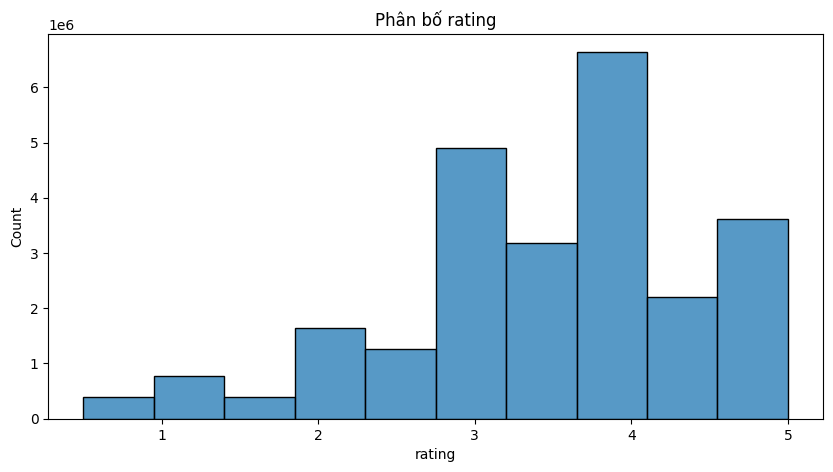


Top 10 phim được xem nhiều nhất:
                                          title  \
108                           Braveheart (1995)   
257   Star Wars: Episode IV - A New Hope (1977)   
292                         Pulp Fiction (1994)   
314            Shawshank Redemption, The (1994)   
351                         Forrest Gump (1994)   
475                        Jurassic Park (1993)   
522                     Schindler's List (1993)   
585            Silence of the Lambs, The (1991)   
2480                         Matrix, The (1999)   
2867                          Fight Club (1999)   

                                genres  
108                   Action|Drama|War  
257            Action|Adventure|Sci-Fi  
292        Comedy|Crime|Drama|Thriller  
314                        Crime|Drama  
351           Comedy|Drama|Romance|War  
475   Action|Adventure|Sci-Fi|Thriller  
522                          Drama|War  
585              Crime|Horror|Thriller  
2480            Action|Sci-Fi|Thril

In [ ]:
# Phân tích cơ bản về dataset
print("Thông tin về dataset:")
print("\nKích thước ratings:", ratings.shape)
print("\nKích thước movies:", movies.shape)
print("\nThông tin về ratings:")
print(ratings.info())
print("\nThông tin về movies:")
print(movies.info())

# Phân tích phân bố rating
plt.figure(figsize=(10, 5))
sns.histplot(data=ratings, x='rating', bins=10)
plt.title('Phân bố rating')
plt.show()

# Top 10 phim được xem nhiều nhất
top_movies = ratings['movieId'].value_counts().head(10)
top_movies_info = movies[movies['movieId'].isin(top_movies.index)]
print("\nTop 10 phim được xem nhiều nhất:")
print(top_movies_info[['title', 'genres']])


Xu hướng rating theo năm:
     rating         
       mean    count
year                
1995  3.667        3
1996  3.546  1430093
1997  3.588   626202
1998  3.513   272099
1999  3.617  1059080
2000  3.575  1735398
2001  3.532  1058750
2002  3.486   776654
2003  3.477   920295
2004  3.431  1048116
2005  3.434  1613550
2006  3.467  1038458
2007  3.472   931432
2008  3.538  1018001
2009  3.506   810127
2010  3.528   792436
2011  3.555   676498
2012  3.615   635208
2013  3.653   515684
2014  3.611   478270
2015  3.557  1604971
2016  3.531  1757440
2017  3.546  1689935
2018  3.564  1310761
2019  3.576  1200634


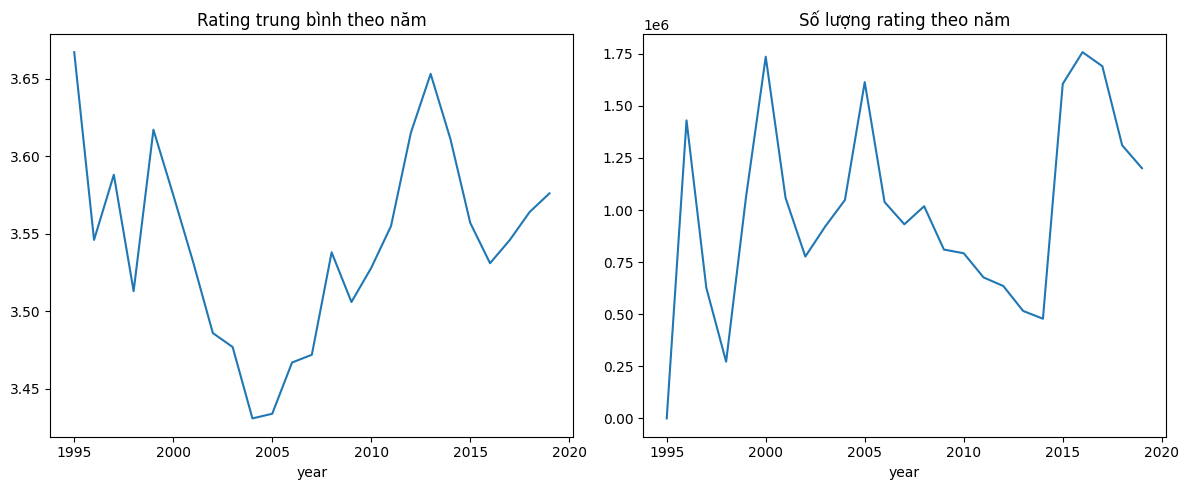

In [ ]:
# Chuyển timestamp thành datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['datetime'].dt.year
ratings['month'] = ratings['datetime'].dt.month

# Phân tích xu hướng theo năm
yearly_stats = ratings.groupby('year').agg({
    'rating': ['mean', 'count']
}).round(3)
print("\nXu hướng rating theo năm:")
print(yearly_stats)

# Vẽ biểu đồ xu hướng
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
yearly_stats['rating']['mean'].plot()
plt.title('Rating trung bình theo năm')
plt.subplot(1, 2, 2)
yearly_stats['rating']['count'].plot()
plt.title('Số lượng rating theo năm')
plt.tight_layout()
plt.show()

In [ ]:
# Helper function to Change the numeric label in terms of Millions

def changingLabels(number):

    return str(number/10**6) + "M"

<ipython-input-24-1b603d7798bc>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])


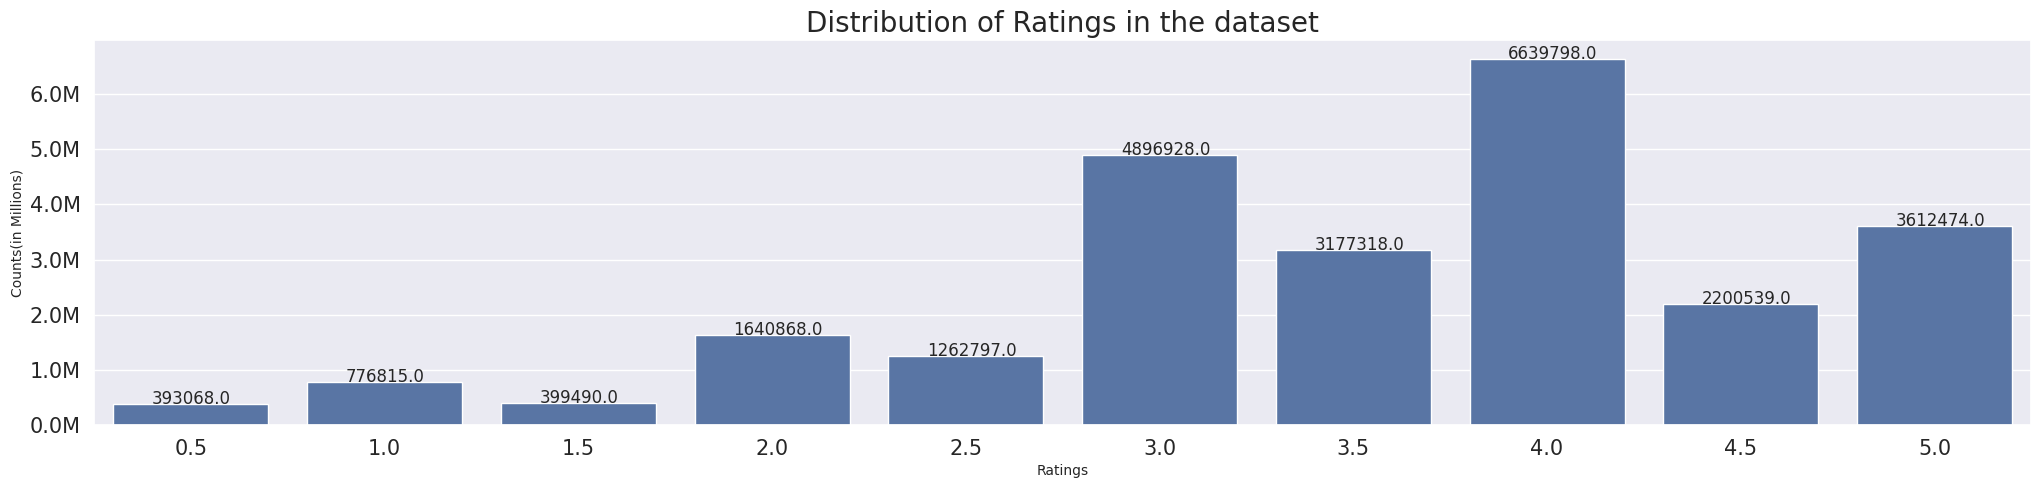

In [ ]:
# Checking the feature "rating"

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot(x="rating", data=ratings, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

In [ ]:
# Checking the feature "date"

print("The count of unique date in the dataset is : ", ratings["date"].nunique())
print("The first rating was given on : ", ratings["date"].min())
print("The latest rating was given on : ", ratings["date"].max())
print("The top 5 date in the dataset are : \n", ratings["date"].value_counts()[:5])

The count of unique date in the dataset is :  8605
The first rating was given on :  1995-01-09
The latest rating was given on :  2019-11-21
The top 5 date in the dataset are : 
 date
2000-11-20    78444
2005-03-22    68531
1999-12-11    57769
2008-10-29    47934
2000-11-21    47381
Name: count, dtype: int64


In [ ]:
# Thống kê cơ bản về ratings
print("Thống kê ratings:")
print(ratings['rating'].describe())

# Top 10 phim được đánh giá nhiều nhất
movie_ratings_count = ratings['movieId'].value_counts().reset_index()
movie_ratings_count.columns = ['movieId', 'count']
top_rated_movies = movie_ratings_count.merge(movies, on='movieId').head(10)
print("\nTop 10 phim được đánh giá nhiều nhất:")
print(top_rated_movies[['title', 'count']])

Thống kê ratings:
count    2.500010e+07
mean     3.533855e+00
std      1.054470e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Top 10 phim được đánh giá nhiều nhất:
                                       title  count
0                        Forrest Gump (1994)  81491
1           Shawshank Redemption, The (1994)  81482
2                        Pulp Fiction (1994)  79672
3           Silence of the Lambs, The (1991)  74127
4                         Matrix, The (1999)  72674
5  Star Wars: Episode IV - A New Hope (1977)  68717
6                       Jurassic Park (1993)  64144
7                    Schindler's List (1993)  60411
8                          Braveheart (1995)  59184
9                          Fight Club (1999)  58773


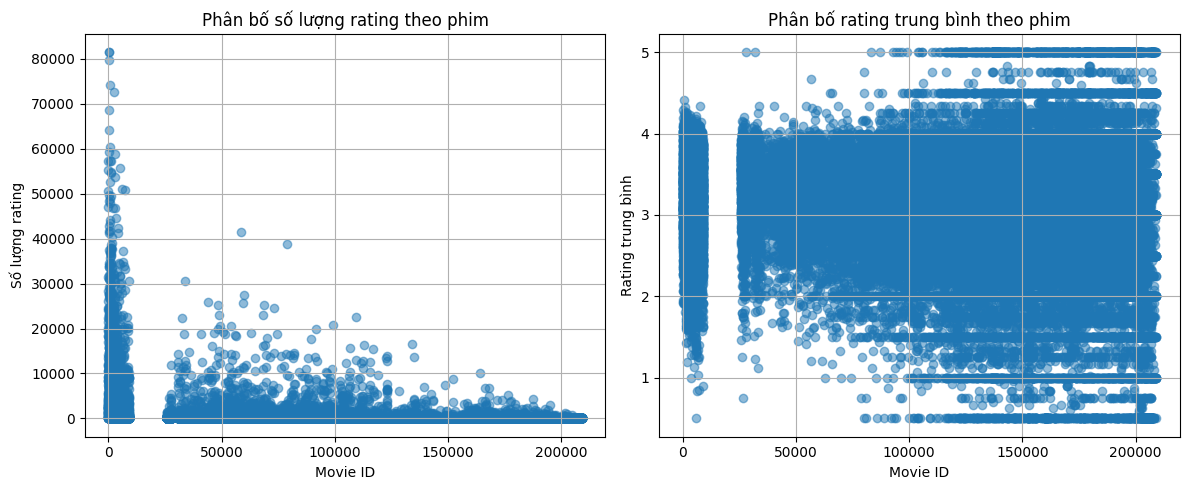


Thống kê về ratings:

Số lượng rating:
count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
Name: num_rating, dtype: float64

Rating trung bình:
count    59047.000000
mean         3.071374
std          0.739847
min          0.500000
25%          2.687500
50%          3.150000
75%          3.500000
max          5.000000
Name: avg_rating, dtype: float64


In [ ]:
# Tính số lượng rating và rating trung bình cho mỗi phim
grouped_ratings = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean']
}).reset_index()
grouped_ratings.columns = ['movieId', 'num_rating', 'avg_rating']

# Tạo biểu đồ
plt.figure(figsize=(12, 5))

# Biểu đồ số lượng rating
plt.subplot(1, 2, 1)
plt.scatter(grouped_ratings['movieId'], grouped_ratings['num_rating'], alpha=0.5)
plt.xlabel('Movie ID')
plt.ylabel('Số lượng rating')
plt.title('Phân bố số lượng rating theo phim')
plt.grid(True)

# Biểu đồ rating trung bình
plt.subplot(1, 2, 2)
plt.scatter(grouped_ratings['movieId'], grouped_ratings['avg_rating'], alpha=0.5)
plt.xlabel('Movie ID')
plt.ylabel('Rating trung bình')
plt.title('Phân bố rating trung bình theo phim')
plt.grid(True)

plt.tight_layout()
plt.show()

# In thêm thống kê
print("\nThống kê về ratings:")
print("\nSố lượng rating:")
print(grouped_ratings['num_rating'].describe())
print("\nRating trung bình:")
print(grouped_ratings['avg_rating'].describe())

50 phim phổ biến và được đánh giá cao nhất:
                                                title  num_rating  avg_rating  \
0                              Planet Earth II (2016)        1124    4.483096   
1                                 Planet Earth (2006)        1747    4.464797   
2                    Shawshank Redemption, The (1994)       81482    4.413576   
3                             Band of Brothers (2001)        1356    4.398599   
4                                              Cosmos         277    4.326715   
5                               Godfather, The (1972)       52498    4.324336   
6                               Blue Planet II (2017)         659    4.289833   
7                          Usual Suspects, The (1995)       55366    4.284353   
8                                   Twin Peaks (1989)         288    4.267361   
9                      Godfather: Part II, The (1974)       34188    4.261758   
10                        Over the Garden Wall (2013)         546

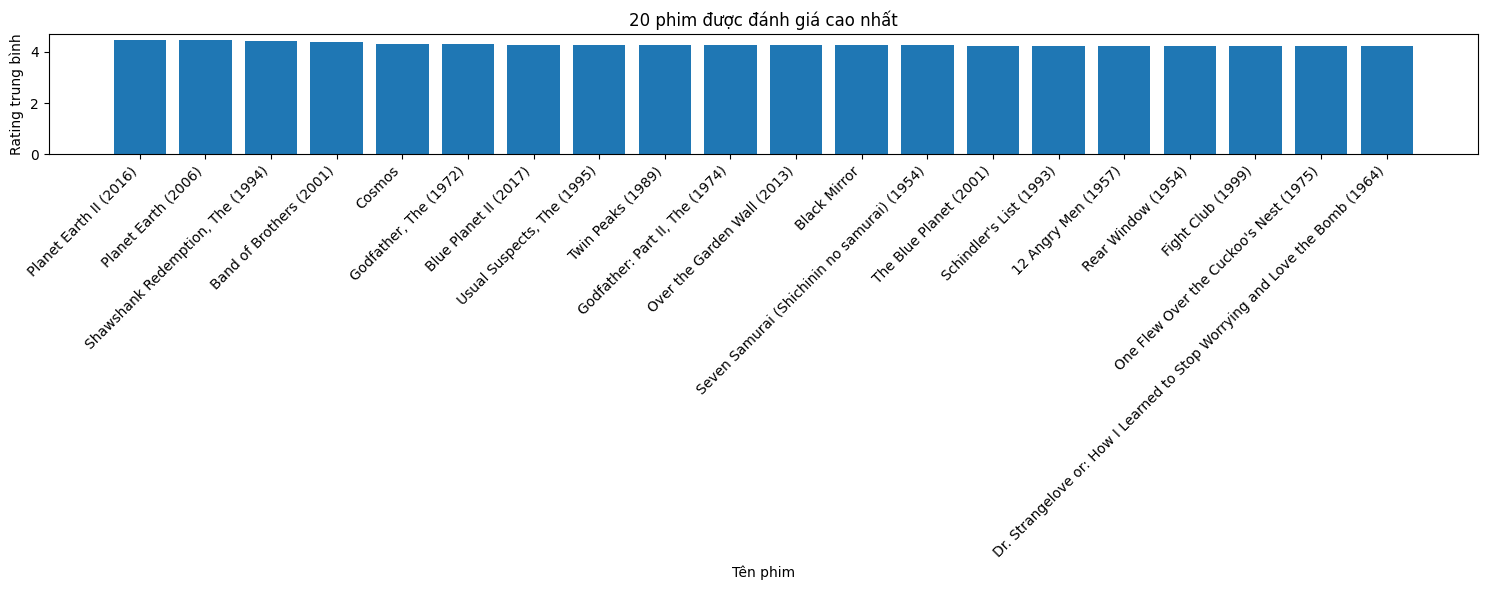

In [ ]:
# Lọc ra các phim phổ biến và được đánh giá cao
popular_movies = grouped_ratings[
    (grouped_ratings['num_rating'] >= 250) & # Phim có ít nhất 250 lượt đánh giá
    (grouped_ratings['avg_rating'] > 4) # Rating trung bình trên 4 sao
].sort_values('avg_rating', ascending=False).head(50)

# Thêm thông tin tên phim và thể loại
popular_movies = popular_movies.merge(movies[['movieId', 'title', 'genres']], on='movieId')

# Hiển thị kết quả
print("50 phim phổ biến và được đánh giá cao nhất:")
print(popular_movies[['title', 'num_rating', 'avg_rating', 'genres']])

# Vẽ biểu đồ cho 20 phim đầu tiên
plt.figure(figsize=(15, 6))
plt.bar(popular_movies['title'].head(20), popular_movies['avg_rating'].head(20))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Tên phim')
plt.ylabel('Rating trung bình')
plt.title('20 phim được đánh giá cao nhất')
plt.tight_layout()
plt.show()

In [ ]:
# Tối ưu bộ nhớ bằng cách chỉ đọc các cột cần thiết
ratings_cols = ['userId', 'movieId', 'rating', 'timestamp']
movies_cols = ['movieId', 'title', 'genres']

ratings = pd.read_csv('/content/drive/MyDrive/Sample_data/ratings.csv', usecols=ratings_cols)
movies = pd.read_csv('/content/drive/MyDrive/Sample_data/movies.csv', usecols=movies_cols)

# Chuyển đổi kiểu dữ liệu để tiết kiệm bộ nhớ
ratings['userId'] = ratings['userId'].astype('int32')
ratings['movieId'] = ratings['movieId'].astype('int32')
ratings['rating'] = ratings['rating'].astype('float32')

In [ ]:
# 1. Tối ưu bộ nhớ
start_mem = ratings.memory_usage().sum() / 1024**2
print('Mức sử dụng bộ nhớ ban đầu: {:.2f} MB'.format(start_mem))

# Tối ưu kiểu dữ liệu cho từng cột
for col in ratings.columns:
    col_type = ratings[col].dtype

    if col_type != object:
        c_min = ratings[col].min()
        c_max = ratings[col].max()

        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                ratings[col] = ratings[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                ratings[col] = ratings[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                ratings[col] = ratings[col].astype(np.int32)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                ratings[col] = ratings[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                ratings[col] = ratings[col].astype(np.float32)

end_mem = ratings.memory_usage().sum() / 1024**2
print('Mức sử dụng bộ nhớ sau khi tối ưu: {:.2f} MB'.format(end_mem))
print('Giảm được {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

Mức sử dụng bộ nhớ ban đầu: 476.84 MB
Mức sử dụng bộ nhớ sau khi tối ưu: 333.79 MB
Giảm được 30.0%


Đánh giá và phân tích xu hướng người dùng

In [ ]:
# 2. Phân tích hành vi người dùng
# Chọn một user ngẫu nhiên để phân tích
sample_user = ratings['userId'].sample(1).iloc[0]
print(f"\nPhân tích hành vi của user {sample_user}")

# Lấy ratings của user đã chọn
user_ratings = ratings[ratings['userId'] == sample_user].copy()

# Chuyển timestamp thành datetime
user_ratings['date'] = pd.to_datetime(user_ratings['timestamp'], unit='s')

# Tính rating trung bình theo tháng
monthly_ratings = user_ratings.groupby(user_ratings['date'].dt.to_period('M'))['rating'].agg(['mean', 'count'])
print("\nRating theo tháng:")
print(monthly_ratings)

# Tìm thể loại yêu thích
user_movies = user_ratings.merge(movies, on='movieId')
genres_split = user_movies['genres'].str.split('|', expand=True).stack()
favorite_genres = genres_split.value_counts().head()
print("\nThể loại yêu thích:")
print(favorite_genres)


Phân tích hành vi của user 75444

Rating theo tháng:
          mean  count
date                 
2005-11  3.525     20

Thể loại yêu thích:
Comedy       10
Adventure     9
Drama         8
Action        7
Fantasy       6
Name: count, dtype: int64


Đánh giá hiệu suất và độ chính xác

In [ ]:
# Tạo pivot table với kích thước nhỏ hơn
n_users = 1000  # Giới hạn số lượng users
top_users = ratings['userId'].value_counts().head(n_users).index

filtered_ratings = ratings[ratings['userId'].isin(top_users)]
user_movie_matrix = filtered_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

# Tính similarity
user_similarity = cosine_similarity(user_movie_matrix)

# Xóa các biến tạm để giải phóng bộ nhớ
del filtered_ratings
gc.collect()

246

In [ ]:
# Tạo ma trận TF-IDF cho genres
tfidf = TfidfVectorizer()
genres_matrix = tfidf.fit_transform(movies['genres'])

# Chọn ngẫu nhiên một phim
random_movie_idx = np.random.randint(0, len(movies))
sample_movie_id = movies['movieId'].iloc[random_movie_idx]
movie_idx = movies[movies['movieId'] == sample_movie_id].index[0]

# Tính similarity với phim được chọn ngẫu nhiên
similarities = cosine_similarity(
    genres_matrix[movie_idx:movie_idx+1],
    genres_matrix
).flatten()

# Lấy top 5 phim tương tự
similar_indices = similarities.argsort()[-6:-1][::-1]
similar_movies = movies.iloc[similar_indices][['title', 'genres']]
print("\nPhim tương tự với", movies.iloc[movie_idx]['title'])
print(similar_movies)

# Thêm dòng này để mỗi lần chạy sẽ cho kết quả khác nhau
np.random.seed(None)


Phim tương tự với Civic Duty (2006)
                                       title          genres
4147                          Chopper (2000)  Drama|Thriller
9200                    Ripley's Game (2002)  Drama|Thriller
44485                       The Booth (2005)  Drama|Thriller
4130            Tailor of Panama, The (2001)  Drama|Thriller
4131   Amores Perros (Love's a Bitch) (2000)  Drama|Thriller



Đánh giá mô hình:
RMSE: 1.0800
MAE: 0.8326
R2 Score: 0.0206


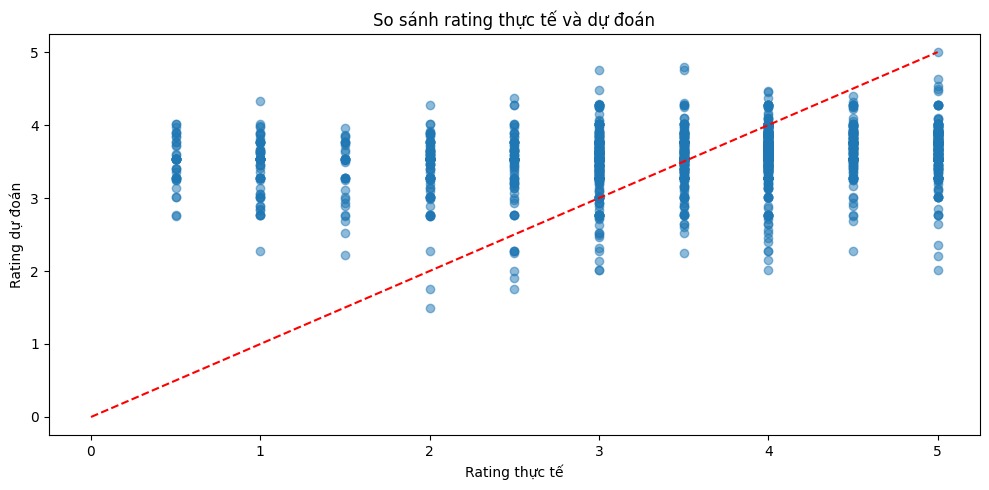

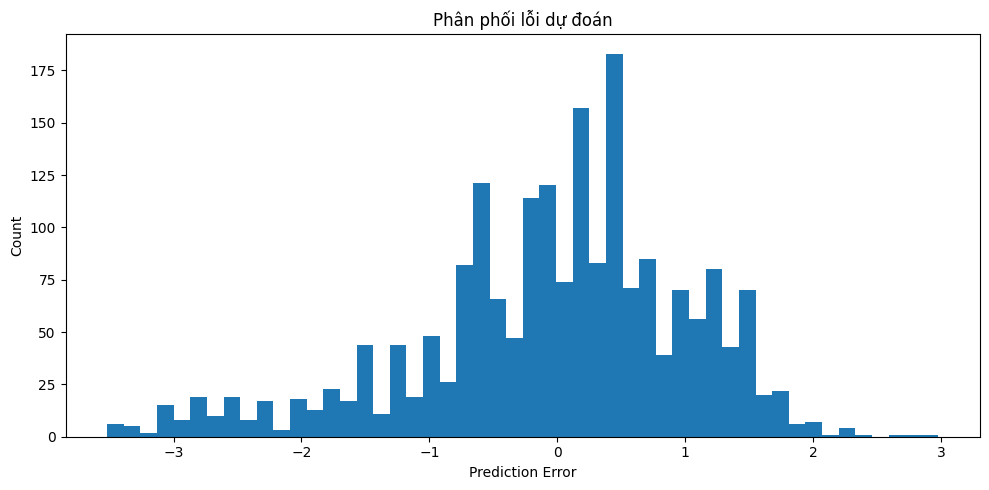

In [ ]:
# Import thư viện cần thiết
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Lấy mẫu nhỏ để test
sample_size = 10000
ratings_sample = ratings.sample(n=sample_size, random_state=42)

# Chia tập train/test
train_data, test_data = train_test_split(
    ratings_sample,
    test_size=0.2,
    random_state=42
)

# Tính trung bình rating theo user và movie
user_mean = train_data.groupby('userId')['rating'].mean().to_dict()
movie_mean = train_data.groupby('movieId')['rating'].mean().to_dict()

# Tính rating trung bình tổng thể
global_mean = train_data['rating'].mean()

# Hàm dự đoán rating
def predict_rating(row):
    user_rating = user_mean.get(row['userId'], global_mean)
    movie_rating = movie_mean.get(row['movieId'], global_mean)
    return (user_rating + movie_rating) / 2

# Áp dụng dự đoán
test_data['predicted_rating'] = test_data.apply(predict_rating, axis=1)

# Tính các metrics đánh giá
rmse = np.sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
mae = mean_absolute_error(test_data['rating'], test_data['predicted_rating'])
r2 = r2_score(test_data['rating'], test_data['predicted_rating'])

print("\nĐánh giá mô hình:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# Vẽ biểu đồ so sánh
plt.figure(figsize=(10, 5))
plt.scatter(test_data['rating'], test_data['predicted_rating'], alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel('Rating thực tế')
plt.ylabel('Rating dự đoán')
plt.title('So sánh rating thực tế và dự đoán')
plt.tight_layout()
plt.show()

# Thêm phân tích phân phối lỗi
errors = test_data['rating'] - test_data['predicted_rating']
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Phân phối lỗi dự đoán')
plt.tight_layout()
plt.show()

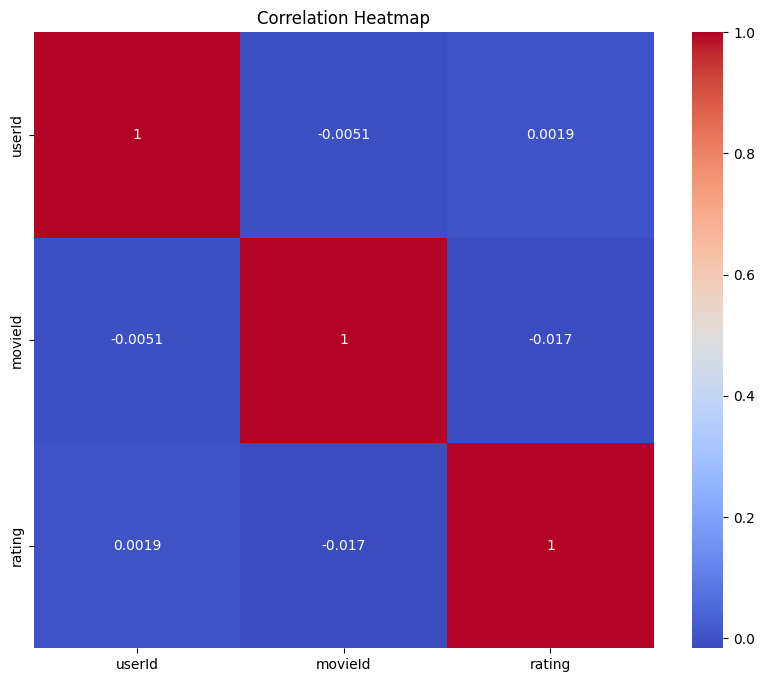

In [ ]:
# 1. Tạo heatmap cho correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = ratings[['userId', 'movieId', 'rating']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# 2. Logistic Regression cho classification
# Chuyển bài toán thành binary classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
ratings['high_rating'] = (ratings['rating'] >= 4).astype(int)

# Chuẩn bị features
X = ratings[['userId', 'movieId']]
y = ratings['high_rating']
# Train với các solver khác nhau
solvers = ['lbfgs', 'liblinear']
for solver in solvers:
    print(f"\nTesting solver: {solver}")
    log_reg = LogisticRegression(solver=solver, max_iter=1000)
    log_reg.fit(X, y)
    y_pred = log_reg.predict(X)
    print(classification_report(y, y_pred))


Testing solver: lbfgs
              precision    recall  f1-score   support

           0       0.53      0.36      0.43  12547284
           1       0.51      0.67      0.58  12452811

    accuracy                           0.52  25000095
   macro avg       0.52      0.52      0.50  25000095
weighted avg       0.52      0.52      0.50  25000095


Testing solver: liblinear
              precision    recall  f1-score   support

           0       0.52      0.49      0.50  12547284
           1       0.51      0.55      0.53  12452811

    accuracy                           0.52  25000095
   macro avg       0.52      0.52      0.52  25000095
weighted avg       0.52      0.52      0.52  25000095



Training Decision Tree...
Training KNN...

Decision Tree Results:
              precision    recall  f1-score   support

           0       0.51      0.78      0.62       989
           1       0.56      0.28      0.37      1011

    accuracy                           0.53      2000
   macro avg       0.54      0.53      0.50      2000
weighted avg       0.54      0.53      0.49      2000


KNN Results:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       989
           1       0.51      0.51      0.51      1011

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



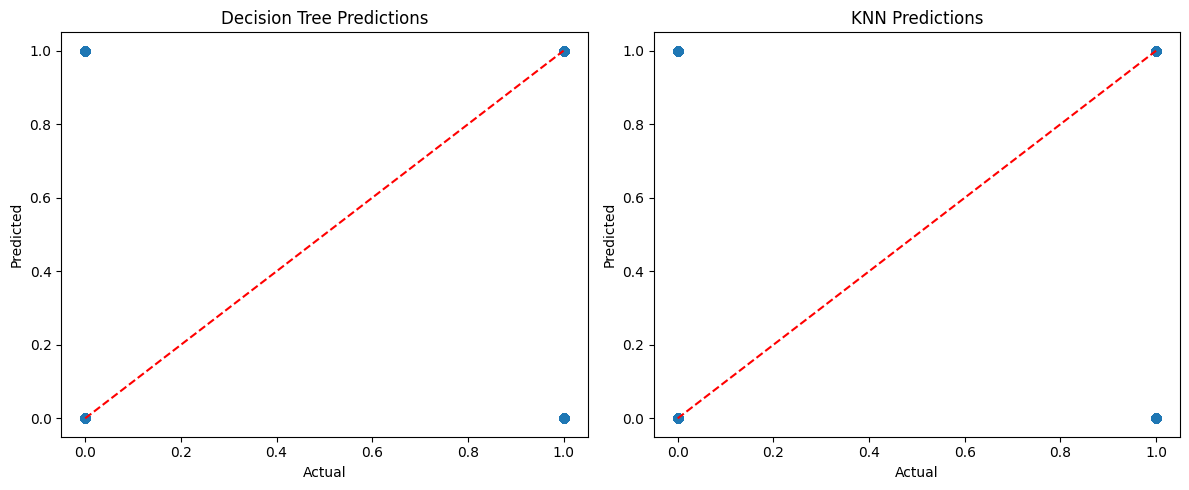

In [ ]:
# Import thư viện
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np

# Lấy mẫu nhỏ để test (10,000 records)
sample_size = 10000
sample_indices = np.random.choice(len(ratings), sample_size, replace=False)
X_sample = X.iloc[sample_indices]
y_sample = y.iloc[sample_indices]

# Chia train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# Decision Tree
print("Training Decision Tree...")
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

# KNN
print("Training KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# So sánh kết quả
print("\nDecision Tree Results:")
print(classification_report(y_test, dt_pred))
print("\nKNN Results:")
print(classification_report(y_test, knn_pred))

# Visualize decision tree results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, dt_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Decision Tree Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, knn_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('KNN Predictions')

plt.tight_layout()
plt.show()


Testing architecture: (32,)
Architecture: (32,)
Training time: 0.39 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.41      0.46       986
           1       0.52      0.62      0.56      1014

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.52      0.52      0.51      2000



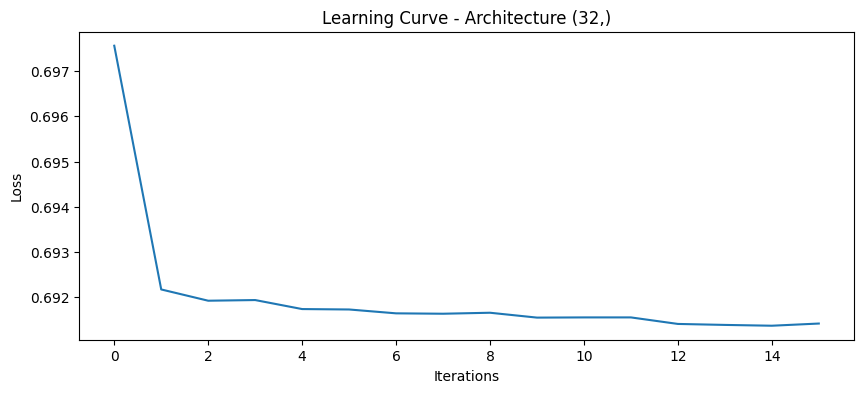


Testing architecture: (64, 32)
Architecture: (64, 32)
Training time: 1.87 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.37      0.43       986
           1       0.51      0.64      0.57      1014

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.51      0.51      0.50      2000



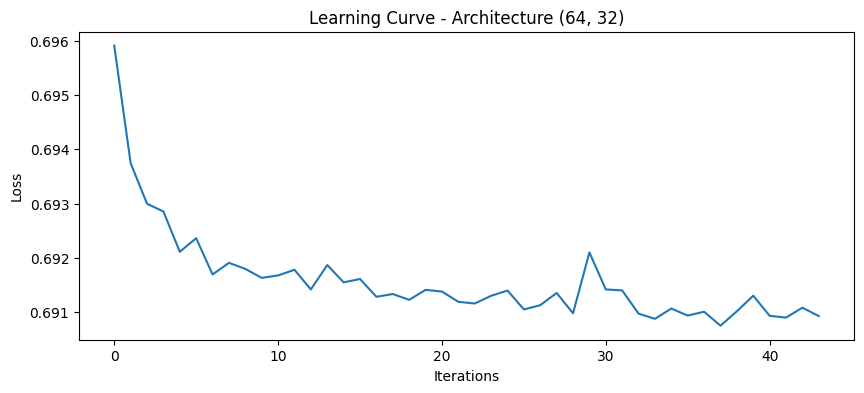

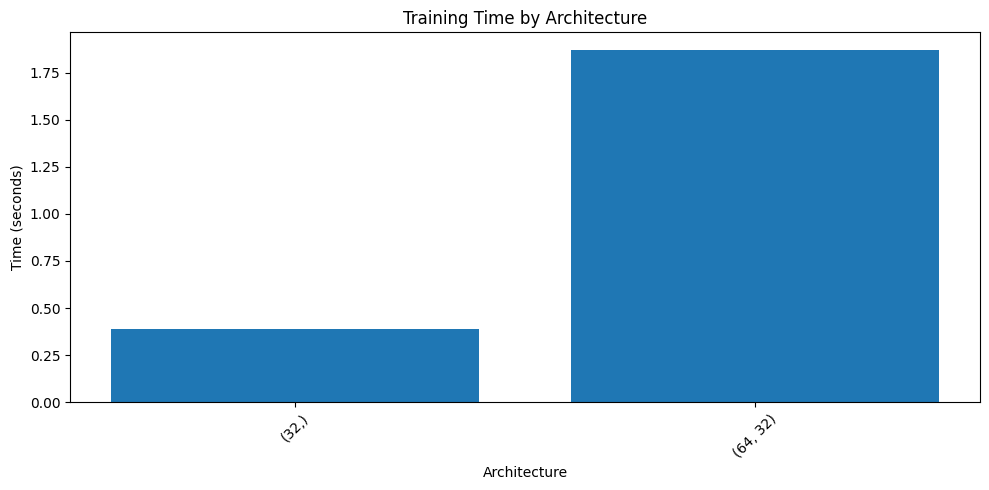

In [ ]:
# 4. Neural Network với các kiến trúc khác nhau
# Import thư viện
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
import time

# Lấy mẫu nhỏ
sample_size = 10000
sample_indices = np.random.choice(len(ratings), sample_size, replace=False)
X_sample = X.iloc[sample_indices]
y_sample = y.iloc[sample_indices]

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thử nghiệm các kiến trúc khác nhau
architectures = [(32,), (64, 32)]
results = {}

for arch in architectures:
    print(f"\nTesting architecture: {arch}")
    start_time = time.time()

    # Tạo và train model
    mlp = MLPClassifier(
        hidden_layer_sizes=arch,
        max_iter=1000,
        learning_rate_init=0.001,
        early_stopping=True,
        random_state=42
    )

    # Training
    mlp.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = mlp.predict(X_test_scaled)

    # Tính thời gian
    training_time = time.time() - start_time

    # Lưu kết quả
    results[str(arch)] = {
        'report': classification_report(y_test, y_pred),
        'time': training_time
    }

    print(f"Architecture: {arch}")
    print(f"Training time: {training_time:.2f} seconds")
    print("Classification Report:")
    print(results[str(arch)]['report'])

    # Vẽ learning curve
    plt.figure(figsize=(10, 4))
    plt.plot(mlp.loss_curve_)
    plt.title(f'Learning Curve - Architecture {arch}')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

# So sánh các kiến trúc
plt.figure(figsize=(10, 5))
architectures_str = [str(arch) for arch in architectures]
times = [results[arch]['time'] for arch in architectures_str]

plt.bar(architectures_str, times)
plt.title('Training Time by Architecture')
plt.xlabel('Architecture')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sampling data...
Splitting data...
Scaling features...

Training SVM with rbf kernel...
Training time: 3.13 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51      1039
           1       0.50      0.58      0.54       961

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.52      2000
weighted avg       0.53      0.53      0.52      2000



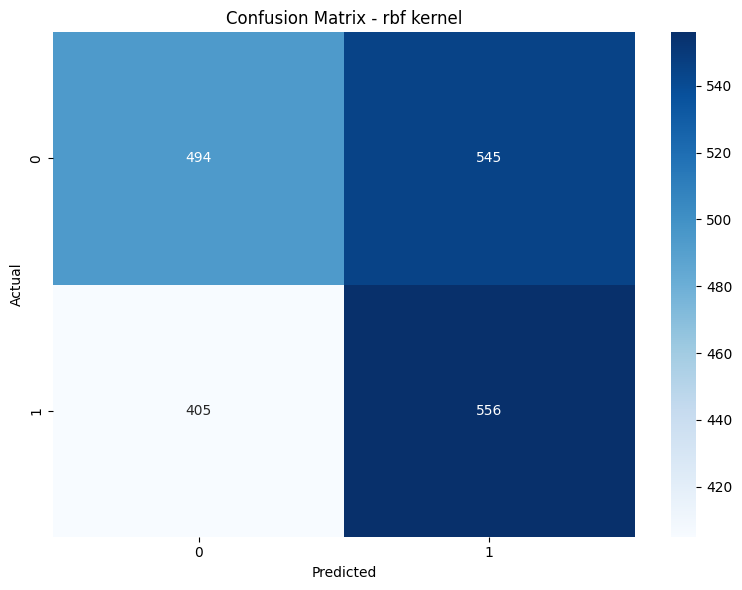




Training SVM with linear kernel...
Training time: 2.74 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      1039
           1       0.47      0.50      0.48       961

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



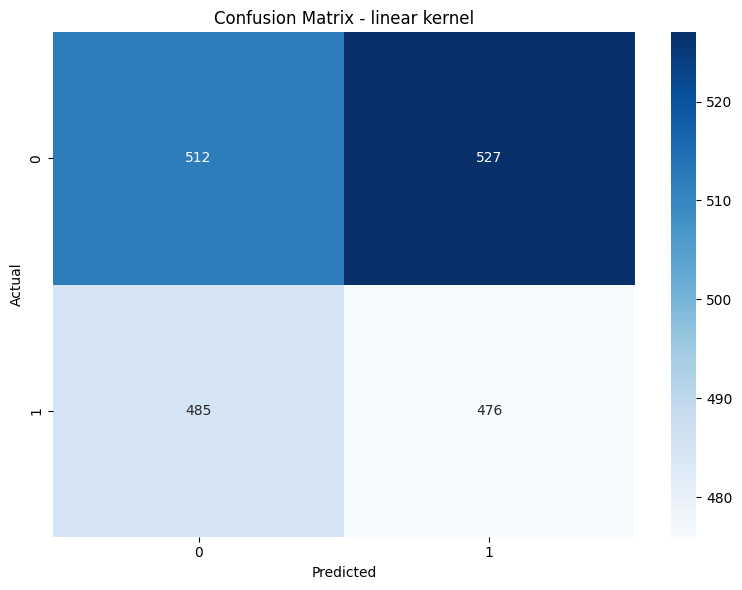

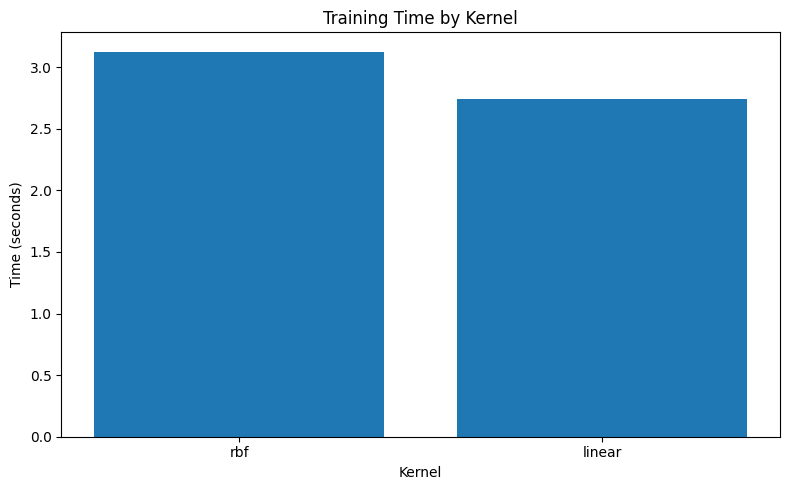

In [ ]:
#SVM Classification
# Import thư viện
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy mẫu nhỏ
print("Sampling data...")
sample_size = 10000
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[sample_indices]
y_sample = y.iloc[sample_indices]

# Chia train/test
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# Chuẩn hóa dữ liệu
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thử nghiệm các kernel khác nhau
kernels = ['rbf', 'linear']
results = {}

for kernel in kernels:
    print(f"\nTraining SVM with {kernel} kernel...")
    start_time = time.time()

    # Train model
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = svm.predict(X_test_scaled)

    # Tính thời gian
    training_time = time.time() - start_time

    # Lưu kết quả
    results[kernel] = {
        'predictions': y_pred,
        'time': training_time
    }

    # In kết quả
    print(f"Training time: {training_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Vẽ confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {kernel} kernel')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Thêm khoảng trống giữa các hình
    print("\n" + "="*50 + "\n")

# Thêm khoảng trống trước biểu đồ cuối
print("\n")

# So sánh thời gian giữa các kernel
plt.figure(figsize=(8, 5))
times = [results[k]['time'] for k in kernels]
plt.bar(kernels, times)
plt.title('Training Time by Kernel')
plt.xlabel('Kernel')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.show()

In [ ]:
# Create a TF-IDF matrix for movie genres
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['genres'])

In [ ]:
# Function for content-based recommendation
def content_based_recommendation(title, tfidf_matrix, movies, num_recommendations=5):
    idx = movies.index[movies['title'] == title].tolist()[0]
    cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    related_movies = sorted(list(enumerate(cosine_similarities)), key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    return [(movies.iloc[i]['title'], cosine) for i, cosine in related_movies]

In [ ]:
# Function to recommend movies using Collaborative Filtering
def collaborative_filtering_recommendation(movie_title, model, movies, num_neighbors=5):
    movie_id = movies[movies['title'] == movie_title].movieId.values[0]
    movie_inner_id = model.trainset.to_inner_iid(movie_id)  # Convert movieId to inner_id in the model
    neighbors = model.get_neighbors(movie_inner_id, k=num_neighbors)

    # Convert from inner_id to movieId and get movie titles
    neighbors_movie_ids = [model.trainset.to_raw_iid(inner_id) for inner_id in neighbors]
    neighbors_titles = movies[movies['movieId'].isin(neighbors_movie_ids)]['title'].tolist()

    return neighbors_titles

In [ ]:
# Hybrid recommendation function combining Content-based and Collaborative Filtering
def hybrid_recommendation(movie_title, tfidf_matrix, model, movies, num_neighbors=5):
    # Content-based recommendations
    content_based_rec = content_based_recommendation(movie_title, tfidf_matrix, movies, num_recommendations=10)

    # Collaborative Filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendation(movie_title, model, movies, num_neighbors)

    # Normalize the scores from Content-based recommendations
    max_cosine = max([cosine for _, cosine in content_based_rec])
    content_based_rec = [(title, cosine / max_cosine) for title, cosine in content_based_rec]

    # Combine results: multiply cosine similarity from Content-based with a weight
    hybrid_rec = {title: cosine for title, cosine in content_based_rec}

    # Add movies from Collaborative Filtering to the recommendation list
    for title in collaborative_filtering_rec:
        if title in hybrid_rec:
            hybrid_rec[title] += 1.0  # Adjust the weight as needed
        else:
            hybrid_rec[title] = 1.0

    # Normalize the scores again to ensure they are between 0 and 1
    max_score = max(hybrid_rec.values())
    hybrid_rec = {title: score / max_score for title, score in hybrid_rec.items()}

    # Sort by highest similarity
    hybrid_rec = sorted(hybrid_rec.items(), key=lambda x: x[1], reverse=True)

    return hybrid_rec

In [ ]:
!pip install transformers

In [ ]:
ratings_subset = ratings.sample(n=500000, random_state=42)
# Reader configuration for surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_subset[['userId', 'movieId', 'rating']], reader)

# Split the data into train/test
trainset, testset = train_test_split(data, test_size=0.2)

# Train the collaborative filtering model (using KNN)
sim_options = {'name': 'cosine', 'user_based': False}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
# Example usage: Hybrid Recommendation for "Toy Story (1995)"
movie_title = "Toy Story (1995)"
hybrid_rec = hybrid_recommendation(movie_title, tfidf_matrix, model, movies, num_neighbors=5)
print(f"Top 10 Recommended Movies for '{movie_title}' (Hybrid):")
for rank, (title, score) in enumerate(hybrid_rec[:10], start=1):
    print(f"{rank}. {title}  {score:.4f}")

Top 10 Recommended Movies for 'Toy Story (1995)' (Hybrid):
1. Antz (1998)  1.0000
2. Toy Story 2 (1999)  1.0000
3. Adventures of Rocky and Bullwinkle, The (2000)  1.0000
4. Emperor's New Groove, The (2000)  1.0000
5. Monsters, Inc. (2001)  1.0000
6. DuckTales: The Movie - Treasure of the Lost Lamp (1990)  1.0000
7. Wild, The (2006)  1.0000
8. Shrek the Third (2007)  1.0000
9. Tale of Despereaux, The (2008)  1.0000
10. Asterix and the Vikings (Astérix et les Vikings) (2006)  1.0000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
# Read data
# https://files.grouplens.org/datasets/movielens/ml-32m.zip
links = pd.read_csv('/content/drive/MyDrive/Sample_data/links.csv')
movies = pd.read_csv('/content/drive/MyDrive/Sample_data/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Sample_data/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/Sample_data/tags.csv')

In [ ]:
# Merge data to get titles and tags
merged_data = pd.merge(tags, movies, on='movieId', how='left')

In [ ]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# Function to represent text with BERT embedding using batch processing
def get_bert_embedding_batch(texts, tokenizer, model, batch_size=8):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.extend(outputs.pooler_output.detach().numpy())
    return np.array(embeddings)

In [ ]:
# Extract tags for each movie
def get_movie_tags(movie_idx, nmf, tfidf_matrix, tfidf_vectorizer):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    topic_distribution = nmf.transform(tfidf_matrix[movie_idx])
    top_topic_idx = topic_distribution.argmax()
    top_topic = nmf.components_[top_topic_idx]
    top_feature_indices = top_topic.argsort()[-10:][::-1]  # Get top 10 features (words) for the topic
    tags = [feature_names[i] for i in top_feature_indices]
    return tags

# Example usage: Get tags for the first movie
movie_idx = 0  # Index of the movie in the dataset
tags = get_movie_tags(movie_idx, nmf, tfidf_matrix, tfidf_vectorizer)
print(f"Recommended tags for '{movies.iloc[movie_idx]['title']}': {tags}")

Recommended tags for 'Toy Story (1995)': ['animation', 'children', 'adventure', 'fantasy', 'musical', 'mystery', 'sci', 'fi', 'imax', 'western']


In [ ]:
import random

In [ ]:
# Function to get tags for a random movie
def get_tags_for_random_movie(movies, nmf, tfidf_matrix, tfidf_vectorizer):
    random_movie = random.choice(movies['title'].tolist())
    tags = get_tags_for_movie(random_movie, movies, nmf, tfidf_matrix, tfidf_vectorizer)
    return random_movie, tags

# Example usage: Get tags for a random movie
random_movie, tags = get_tags_for_random_movie(movies, nmf, tfidf_matrix, tfidf_vectorizer)
print(f"Recommended tags for '{random_movie}': {tags}")

Recommended tags for 'Almost Adults (2017)': ['romance', 'musical', 'fantasy', 'western', 'war', 'mystery', 'adventure', 'noir', 'film', 'drama']
